# Lab 3: Advanced CNN architectures



The improved training pipeline for SimpleNN developed in Lab (2) still has limited performance. This is mainly because the SimpleNN has a rather small capacity (learning capability) for the CIFAR-10 task. Thus, in this lab, we replace the SimpleNN model with a more advanced ResNet [3] architecture. We expect to see much higher accuracy on CIFAR-10 when using ResNets. Here, you may duplicate your jupyter notebook for Lab (2) as resnet-cifar10.ipynb to serve as a starting point.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
sys.path.append('/content/drive/MyDrive/2023 - Duke/2025-01/ECE661_ComputerEngineeringMachineLearning&DeepNeuralNets/Assigments/HW2')


Mounted at /content/drive


In [ ]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies, title=None):
    best_val_accuracy = max(val_accuracies)
    best_val_loss = min(val_losses)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.plot(range(EPOCHS), train_losses, label='Training Loss', color='red')
    ax1.plot(range(EPOCHS), val_losses, label='Validation Loss', color='orange')
    ax1.set_title(f'Training vs Validation Loss\nBest Validation Loss: {best_val_loss:.4f}')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(range(EPOCHS), train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(range(EPOCHS), val_accuracies, label='Validation Accuracy', color='green')
    ax2.set_title(f'Training vs Validation Accuracy\nBest Validation Accuracy: {best_val_accuracy:.4f}')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    if title:
        fig.suptitle(title, fontsize=16, y=1.05)

    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies, title=None):
    best_val_accuracy = max(val_accuracies)
    best_val_loss = min(val_losses)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.plot(range(EPOCHS), train_losses, label='Training Loss', color='red')
    ax1.plot(range(EPOCHS), val_losses, label='Validation Loss', color='orange')
    ax1.set_title(f'Training vs Validation Loss\nBest Validation Loss: {best_val_loss:.4f}')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(range(EPOCHS), train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(range(EPOCHS), val_accuracies, label='Validation Accuracy', color='green')
    ax2.set_title(f'Training vs Validation Accuracy\nBest Validation Accuracy: {best_val_accuracy:.4f}')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    if title:
        fig.suptitle(title, fontsize=16, y=1.05)

    plt.tight_layout()
    plt.show()


In [ ]:
#############################################
# GPU check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")
#############################################

Run on GPU...


In [ ]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])
#############################################

In [ ]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT,
    mode='train',
    download=True,
    transform=transform_train
)
val_set = CIFAR10(
    root=DATA_ROOT,
    mode='val',
    download=True,
    transform=transform_val
)

test_set = CIFAR10(
    root=DATA_ROOT,
    mode='test',
    download=True,
    transform=transform_val
)

# construct dataloader
train_loader = DataLoader(
    train_set,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
val_loader = DataLoader(
    val_set,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

test_loader = DataLoader(
    test_set,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

#############################################

Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_test_F22.zip
Extracting ./data/cifar10_test_F22.zip to ./data
Files already downloaded and verified


 ## Simple neural network with batch normalization, a learning rate of 0.1, ReLU activation, and a learning rate decay of 0.1 every 10 epochs, to be used for comparison with ResNet

In [ ]:
import torch.optim as optim

# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 0.1

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.7652, Training accuracy: 0.3401
Validation loss: 1.4673, Validation accuracy: 0.4664

Epoch 1:
Training loss: 1.4531, Training accuracy: 0.4698
Validation loss: 1.3100, Validation accuracy: 0.5318

Epoch 2:
Training loss: 1.3320, Training accuracy: 0.5189
Validation loss: 1.2606, Validation accuracy: 0.5482

Epoch 3:
Training loss: 1.2589, Training accuracy: 0.5506
Validation loss: 1.1211, Validation accuracy: 0.5992

Epoch 4:
Training loss: 1.2036, Training accuracy: 0.5729
Validation loss: 1.1415, Validation accuracy: 0.5904

Epoch 5:
Training loss: 1.1516, Training accuracy: 0.5909
Validation loss: 1.1047, Validation accuracy: 0.6024

Epoch 6:
Training loss: 1.1179, Training accuracy: 0.6012
Validation loss: 1.0512, Validation accuracy: 0.6244

Epoch 7:
Training loss: 1.0786, Training accuracy: 0.6174
Validation loss: 1.0105, Validation accuracy: 0.6448

Epoch 8:
Training loss: 1.0543, Training accuracy: 0.6266
Validation loss: 1.0652, 

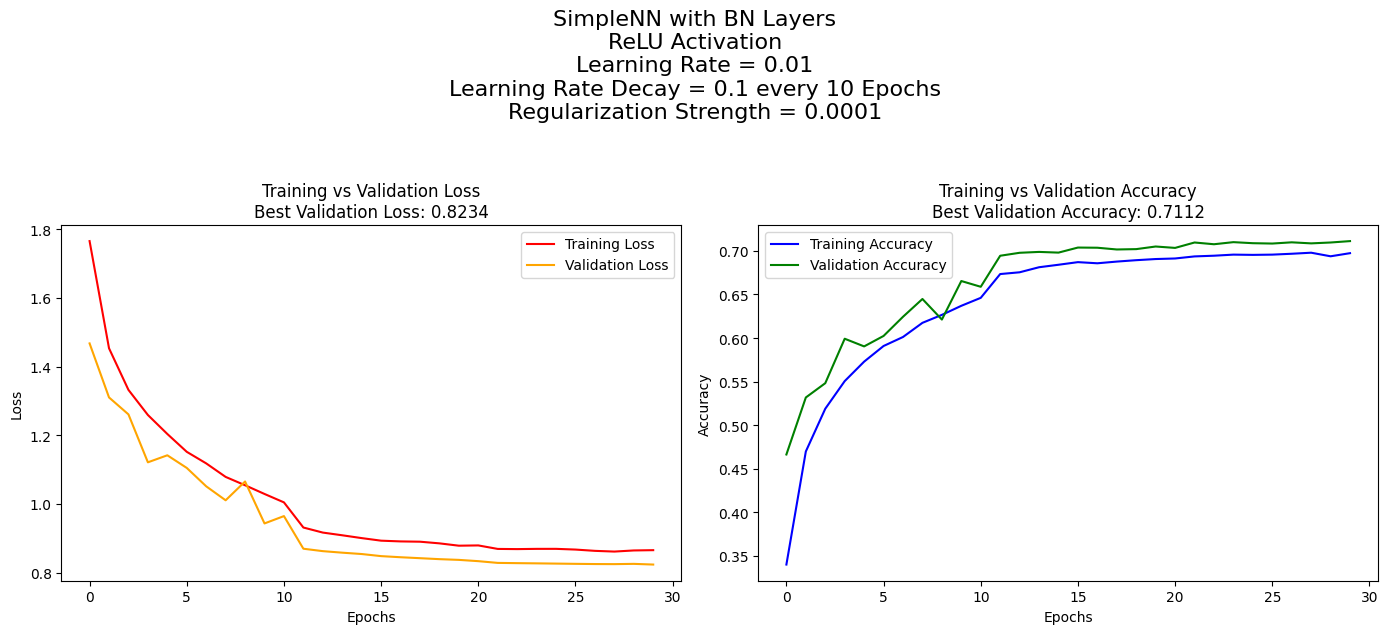

In [ ]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"SimpleNN with BN Layers\nReLU Activation\nLearning Rate = {INITIAL_LR}\nLearning Rate Decay = 0.1 every 10 Epochs\nRegularization Strength = {REG}")

## (a)	(8 pts) Implement the ResNet-20 architecture by following Section 4.2 of the ResNet paper [3]. This lab is designed to have you learn how to implement a DNN model yourself, so do NOT borrow any code from online resource.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet20(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet20, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self._make_layer(ResidualBlock, 16, 6, stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 32, 6, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 64, 6, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


# Model Definition
net = ResNet20()
net = net.to(device)


# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 0.1

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'ResNet20.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.8872, Training accuracy: 0.2903
Validation loss: 1.7189, Validation accuracy: 0.3480

Epoch 1:
Training loss: 1.5454, Training accuracy: 0.4268
Validation loss: 1.6165, Validation accuracy: 0.4344

Epoch 2:
Training loss: 1.2798, Training accuracy: 0.5374
Validation loss: 1.2272, Validation accuracy: 0.5694

Epoch 3:
Training loss: 1.0539, Training accuracy: 0.6239
Validation loss: 1.3952, Validation accuracy: 0.5312

Epoch 4:
Training loss: 0.8854, Training accuracy: 0.6881
Validation loss: 0.9059, Validation accuracy: 0.6880

Epoch 5:
Training loss: 0.7618, Training accuracy: 0.7330
Validation loss: 0.7851, Validation accuracy: 0.7288

Epoch 6:
Training loss: 0.6854, Training accuracy: 0.7617
Validation loss: 0.7462, Validation accuracy: 0.7550

Epoch 7:
Training loss: 0.6244, Training accuracy: 0.7850
Validation loss: 0.7281, Validation accuracy: 0.7592

Epoch 8:
Training loss: 0.5767, Training accuracy: 0.8025
Validation loss: 0.6638, 

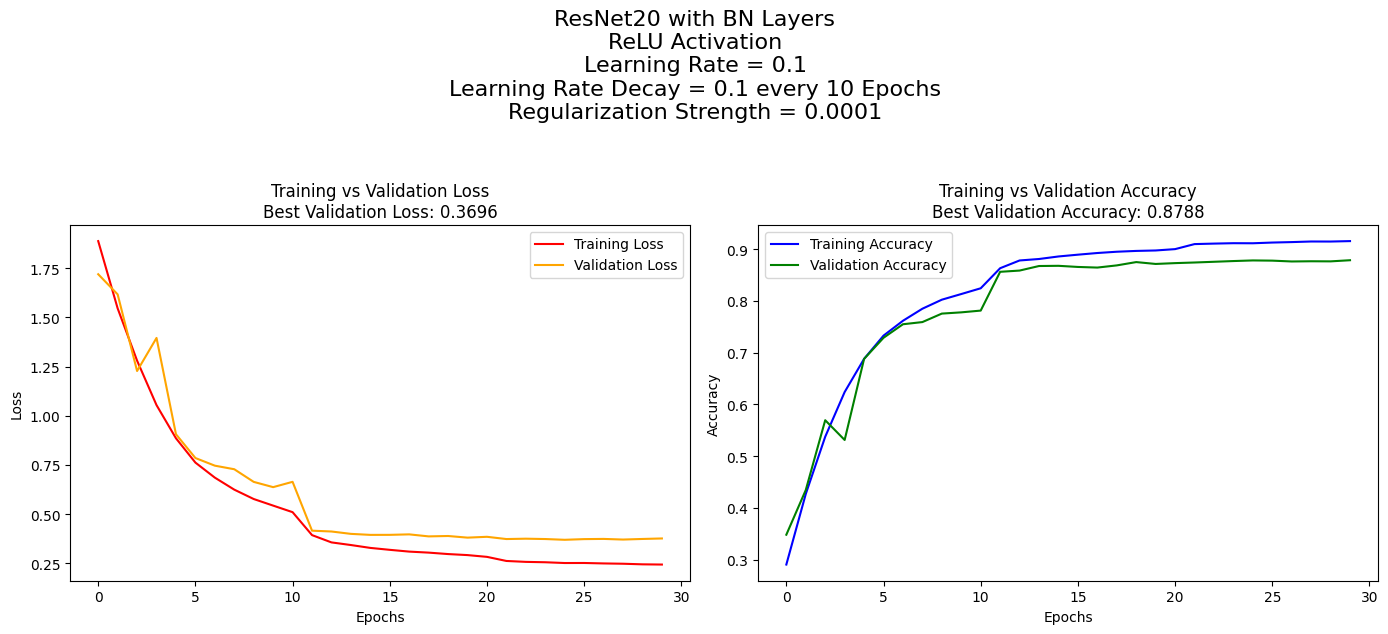

In [ ]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"ResNet20 with BN Layers\nReLU Activation\nLearning Rate = {INITIAL_LR}\nLearning Rate Decay = {DECAY} every {DECAY_EPOCHS} Epochs\nRegularization Strength = {REG}")

(b)	(12 pts) Tune your ResNet-20 model to reach an accuracy of higher than 90% on the validation dataset. You may use all of the previous techniques that you have learned so far, including data augmentations, hyperparameter tuning, learning rate decay, etc. Training the model longer is also essential to obtaining good performance. You should be able to achieve >90% validation accuracy with a maximum of 200 epochs. Remember to save your trained model during the training!!! Check out this tutorial https://pytorch.org/tutorials/beginner/saving_loading_models.html on model saving/loading.

Note: We will grade this task by evaluating your trained model on the holdout testing dataset (which you do not have any labels). After your ResNet-20 model is trained, you need to make predictions on test data, and save the predictions into the predictions.csv file. Please utilize the given notebook, save_test_predictions.ipynb, to save your predictions in required format. The saved file should look like the provided example sample_predictions.csv. Upon submission, we will directly compare your predicted labels with the ground-truth labels to compute your score.

In [ ]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet20(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet20, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self._make_layer(ResidualBlock, 16, 6, stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 32, 6, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 64, 6, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


# Model Definition
net = ResNet20()
net = net.to(device)


# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 200
#DECAY_EPOCHS = 10
DECAY = 0.1

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    #if i % DECAY_EPOCHS == 0 and i != 0:
    if i == 90 or i == 140:  #(close to 32k and 48k iteration)
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'ResNet20.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.8759, Training accuracy: 0.3022
Validation loss: 1.8125, Validation accuracy: 0.3196
Saving ...

Epoch 1:
Training loss: 1.5374, Training accuracy: 0.4338
Validation loss: 1.4109, Validation accuracy: 0.4698
Saving ...

Epoch 2:
Training loss: 1.2747, Training accuracy: 0.5378
Validation loss: 1.1917, Validation accuracy: 0.5854
Saving ...

Epoch 3:
Training loss: 1.0408, Training accuracy: 0.6285
Validation loss: 1.0417, Validation accuracy: 0.6406
Saving ...

Epoch 4:
Training loss: 0.8723, Training accuracy: 0.6917
Validation loss: 0.8611, Validation accuracy: 0.7028
Saving ...

Epoch 5:
Training loss: 0.7556, Training accuracy: 0.7357
Validation loss: 0.7032, Validation accuracy: 0.7582
Saving ...

Epoch 6:
Training loss: 0.6719, Training accuracy: 0.7670
Validation loss: 0.7113, Validation accuracy: 0.7676
Saving ...

Epoch 7:
Training loss: 0.6068, Training accuracy: 0.7887
Validation loss: 0.6575, Validation accuracy: 0.7730
Saving 

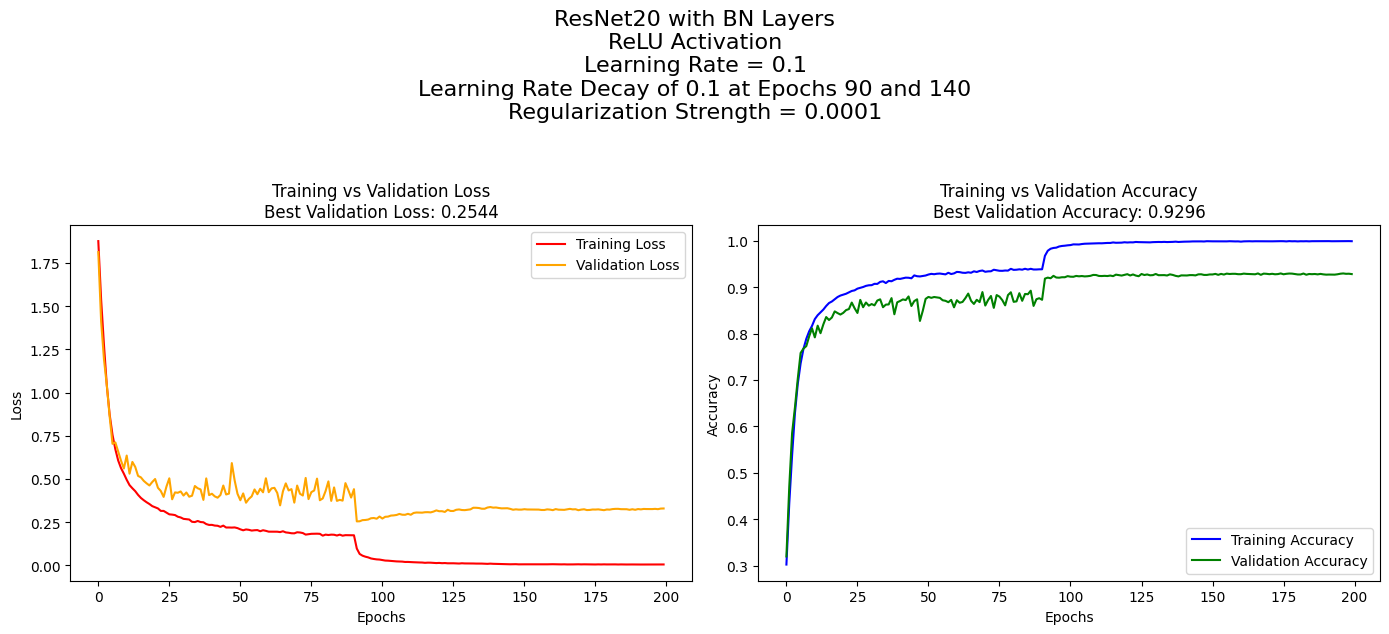

In [ ]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"ResNet20 with BN Layers\nReLU Activation\nLearning Rate = {INITIAL_LR}\nLearning Rate Decay of 0.1 at Epochs 90 and 140\nRegularization Strength = {REG}")


In [ ]:
import pandas as pd

# Load the trained model
checkpoint = torch.load(os.path.join(CHECKPOINT_FOLDER, 'ResNet20.pth'), weights_only=True)
net.load_state_dict(checkpoint['state_dict'])
net = net.to(device)
net.eval()

# Make predictions on the test set
predictions = []
with torch.no_grad():  # Disable gradient computation for predictions
    for batch_idx, (inputs) in enumerate(test_loader):  # test set
        inputs = inputs.to(device)

        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())

# Save the predictions
test_ids = list(range(len(predictions)))
prediction_df = pd.DataFrame({
    'Id': test_ids,
    'Label': predictions
})


prediction_df.to_csv('/content/predictions.csv', index=False)
prediction_df

,Id,Label
0,0,2
1,1,3
2,2,5
3,3,0
4,4,5
...,...,...
9995,9995,1
9996,9996,9
9997,9997,4
9998,9998,2
